# PROJECT-3. Анализ воронки 

In [455]:
# импортируем нужные библиотеки
import pandas as pd
import psycopg2
import psycopg2.extras 
import numpy as np
from collections import Counter
from IPython.display import Image
from io import StringIO
import requests

### ПРОВЕРЯЕМ СЛЕДУЮЩИЕ ГИПОТЕЗЫ:
**Гипотеза 1:**
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?   
**Гипотеза 2:**   
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?    
**Гипотеза 3:**
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

## ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении.

## ЗАДАЧИ
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

## КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

**Этапы игры**
* Регистрация
* Старт обучения	
* Завершение обучения	
* Выбор уровня сложности вопросов	
* Выбор пакетов вопросов	
* Покупка платных пакетов вопросов


**Таблица Event**
Хранит данные о событиях, которые совершают пользователи. По сути, каждое событие — это факт прохождения пользователем какого-либо этапа игры.

* id	идентификатор события
* user_id	уникальный идентификатор пользователя, совершившего событие в приложении
* start_time	дата и время события
* event_type	тип события, значения: 
   * registration — регистрация; 
   * tutorial_start — начало обучения; 
   * tutorial_finish — завершение обучения; 
   * level_choice — выбор уровня сложности; 
   * pack_choice — выбор пакетов вопросов
* tutorial_id	идентификатор обучения (этот идентификатор есть только у событий обучения)
* selected_level	выбранный уровень сложности обучения

In [456]:
# чтение файла event из google диска
orig_url1='https://drive.google.com/file/d/1RlnwSJx88ceKQSn0wIveapo2UWpI1AgI/view?usp=sharing'
file_id1 = orig_url1.split('/')[-2]
dwn_url1='https://drive.google.com/uc?export=download&id=' + file_id1
url1 = requests.get(dwn_url1).text
csv_raw1 = StringIO(url1)
dfs1 = pd.read_csv(csv_raw1)
event = pd.DataFrame(dfs1)
# event = pd.read_csv('data/7_4_Events.csv') # чтение файла с локального диска

In [457]:
# фильтруем только 2018 г и преобразовываем
mask1 = (event['start_time']>='2018-01-01') & (event['start_time']<'2019-01-01') & (event['event_type']=='registration') # условие фильтрации: все зарегистрированные
registered = event[mask1]['user_id'].unique() # список всех зарегестрированных пользователей

events_df = event[event['user_id'].isin(registered)] # фильтрация таблицы по списку ID
events_df['start_time'] = pd.to_datetime(events_df['start_time']) # преобразование даты
events_df = events_df.rename(columns={"id": "event_id"}) # переименование колонок
events_df.head() # просмотр первых 5 строк таблицы

<ipython-input-457-49f5d216ce18>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['start_time'] = pd.to_datetime(events_df['start_time']) # преобразование даты


,event_id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836


In [458]:
# чтение файла purchase из google диска
orig_url2='https://drive.google.com/file/d/1aWp7dWHtFX3v0g1H4Ns0pHKpSyHZUf78/view?usp=sharing'
file_id2 = orig_url2.split('/')[-2]
dwn_url2='https://drive.google.com/uc?export=download&id=' + file_id2
url2 = requests.get(dwn_url2).text
csv_raw2 = StringIO(url2)
dfs2 = pd.read_csv(csv_raw2)
purchase = pd.DataFrame(dfs2)
# purchase = pd.read_csv('data/purchase.csv') # чтение файла с локального диска

In [459]:
# фильтруем только 2018 г и преобразовываем
purchase_df = purchase[purchase['user_id'].isin(registered)] # фильтрация таблицы по списку ID
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime']) # преобразование даты
purchase_df['event_type'] = 'purchase'
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"}) # переименование колонок

purchase_df.head() # просмотр первых 5 строк таблицы

<ipython-input-459-f89000b9ae71>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime']) # преобразование даты
<ipython-input-459-f89000b9ae71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_df['event_type'] = 'purchase'


,purchase_id,user_id,start_time,amount,event_type
1171,16845,27845,2018-01-03 18:53:43,100,purchase
1172,16846,27865,2018-01-04 14:46:10,250,purchase
1174,16848,27911,2018-01-07 08:19:12,50,purchase
1175,16849,27910,2018-01-07 12:11:34,100,purchase
1176,16850,27940,2018-01-07 13:16:41,200,purchase


In [460]:
""" Сделаем объединенный датафрейм из событий и оплат"""

total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df['start_time'] = pd.to_datetime(total_events_df['start_time']) # преобразование даты
total_events_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 51405 to 2778
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.7+ MB


In [461]:
"""Сформируем группы"""

mask2 = (event['start_time']>='2018-01-01') & (event['start_time']<'2019-01-01') & (event['event_type']=='tutorial_start') # условие фильтрации: все начинавшие обучение
learners  = event[mask2]['user_id'].unique() # список всех начавших обучение
mask3 = (event['start_time']>='2018-01-01') & (event['start_time']<'2019-01-01') & (event['event_type']=='tutorial_finish') # условие фильтрации: все окончившие обучение
graduated = event[mask3]['user_id'].unique()# список всех окончивших обучение
non_learners = list((Counter(registered) - Counter(learners)).elements())

In [462]:
print("Количество зарегистрированных пользователей: {}".format(len(registered)))
print("Количество пользователей, начинавших обучение: {}".format(len(learners)))
print("Количество пользователей, окончивших обучение: {}".format(len(graduated)))
print("Количество пользователей, не начинавших обучение: {}".format(len(non_learners)))

Количество зарегистрированных пользователей: 19926
Количество пользователей, начинавших обучение: 11856
Количество пользователей, окончивших обучение: 10248
Количество пользователей, не начинавших обучение: 8070


In [465]:
# Обозначим название группы с типом события в виде словаря
user_groups = [
    {'не проходившие обучение': non_learners},
    {'окончившие обучение': graduated},
]
list1 = []
# проссматриваем показатели по группам
for group in user_groups:
    
    level = list(group.keys())[0] # название группы
    group_users = group[level] # тип события
    count_of_users_in_group = len(group_users) # количество пользователей в группе
    purchase_df_slice = purchase_df[purchase_df['user_id'].isin(group_users)] # датафарм по группе
    percent_of_purchase = purchase_df_slice['user_id'].nunique()/count_of_users_in_group # Процент оплативших пользователей, из группы не проходившие обучение
    print ('Процент оплативших пользователей, из группы {}: {:.2%}'.format(level,percent_of_purchase))
    level_choice_df = total_events_df[(total_events_df['event_type'] == 'level_choice') & (total_events_df['user_id'].isin(group_users))] # датафарм# датафарм с выбором уровня сложности по группе
        
    if (level_choice_df['user_id'].value_counts().mean()) == 1:
        
        level_choice_df = level_choice_df[['user_id','start_time']].rename(columns={'start_time':'level_choice_time'}) # датафарм: ID пользователя и дата выбора уровня сложности
        purchase_df_slice_2 = purchase_df_slice[['user_id','start_time']].rename(columns={'start_time':'purchase_time'}) # датафарм: ID пользователя и дата покупки
        
        merged_df = purchase_df_slice_2.merge(level_choice_df,on='user_id',how='inner') # объедененный датафарм: ID пользователя и дата выбора уровня сложности, дата покупки
        merged_df['timedelta'] = merged_df['purchase_time'] - merged_df['level_choice_time'] # добавляем поле количество дней, между покупкой и выбором уровня сложности
        merged_df['timedelta'] = merged_df['timedelta']/pd.to_timedelta('1 hour') # перевод данных в формат часов
        mean_time = round(merged_df['timedelta'].mean(),1) # среднее значение количество дней, между покупкой и выбором уровня сложности
        list1.append(mean_time)
        print ('Среднее время между выбором уровня сложности и оплатой для пользователей группы {}: {} час.'.format(level,mean_time))
        print ()
    else:
        print ('Более 1 события выбора уровня сложности')

Процент оплативших пользователей, из группы не проходившие обучение: 0.27%
Среднее время между выбором уровня сложности и оплатой для пользователей группы не проходившие обучение: 100.9 час.

Процент оплативших пользователей, из группы окончившие обучение: 14.12%
Среднее время между выбором уровня сложности и оплатой для пользователей группы окончившие обучение: 89.4 час.



In [466]:
diagram_df = pd.DataFrame ({
    'group': ['non_learners','graduated'],
    'mean_time': list1
})

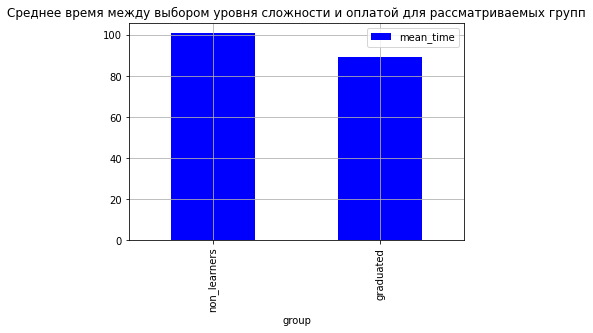

In [467]:
# визуализируем данные на гистограмме
diagram_df.plot(
    kind='bar',
    grid=True,
    figsize=(6, 4),
    title= 'Среднее время между выбором уровня сложности и оплатой для рассматриваемых групп',
    colormap='winter',
    x= 'group',
    y= 'mean_time',
);

In [469]:
a = list1[0]-list1[1]
print ('Время между выбором уровня сложности и оплатой на {} часов меньше для пользователей, завершивших обучение по сравнению с тем, кто его не проходил'.format(a))

Время между выбором уровня сложности и оплатой на 11.5 часов меньше для пользователей, завершивших обучение по сравнению с тем, кто его не проходил


## ВЫВОД
Время между выбором уровня сложноси и оплатой на 11,5 часов меньше, для пользователей которые прошли обучение в сравнению с тем, кто его не начинал.

## Проверяем 2-ю гипотезу:

In [485]:
# фильтруем наш датафрем по группе закончивших обучение
total_events_graduated_df = total_events_df[total_events_df['user_id'].isin(graduated)]
# создаем наш датафрем по сумме оплат по каждому ID пользователя
amount_df = pd.DataFrame(total_events_graduated_df.groupby('user_id')['amount'].sum())
# выделяем датафрем по окончившим обучение
total_events_graduated_df = total_events_graduated_df[total_events_graduated_df['event_type']=='tutorial_finish']
# группируем по количеству раз окончания обучения, считаем количество пользователей
number_learners_df = pd.DataFrame(total_events_graduated_df.groupby('user_id')['event_type'].count())
number_learner2_df = pd.DataFrame(number_learners_df.value_counts())

In [486]:
# подтягиваем в нашу таблицу оплаты
merged2_df = number_learners_df.merge(amount_df,on='user_id',how='inner')
# фильтруем только те, по которым были оплаты
merged2_df = merged2_df[merged2_df['amount']>0]
#считаем количество пользователей, по которым были оплаты в зависимости от того сколько раз завершали обучение
amount2_df = pd.DataFrame(merged2_df.groupby('event_type')['amount'].count())

In [487]:
# соединяем 2 датафрейма:
merged3_df = amount2_df.merge(number_learners2_df,on='event_type',how='inner')
merged3_df.columns = ['number_users_graduated', 'number_users_amount'] # переименовываем столбцы
merged3_df['percent_conversion'] = round(merged3_df['number_users_amount']/merged3_df['number_users_graduated']*100,1) # добавляем столбец с конверсией
merged3_df

,number_users_graduated,number_users_amount,percent_conversion
event_type,,,
1,1143,8013,701.0
2,182,1321,725.8
3,44,345,784.1
4,19,178,936.8
5,19,117,615.8
6,15,101,673.3
7,15,97,646.7
8,6,54,900.0
9,4,22,550.0


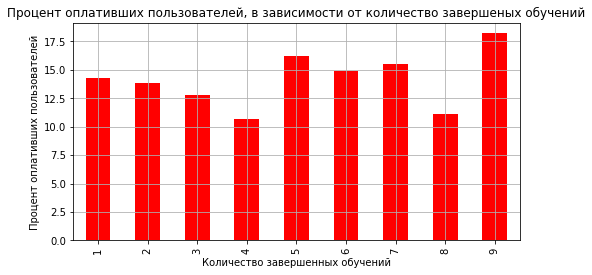

In [475]:
# визуализируем данные на гистограмме
percent_conversion_df = merged3_df['percent_conversion']
percent_conversion_df.plot(
    kind='bar',
    grid=True,
    figsize=(8, 4),
    title= 'Процент оплативших пользователей, в зависимости от количество завершеных обучений',
    colormap='prism',
    xlabel= 'Количество завершенных обучений',
    ylabel= 'Процент оплативших пользователей'
);


## ВЫВОД
Проанализировав конверсию оплат по пользователям окончившим обучение в разрезе групп по количеству завершенных обучений, понимаем, что зависимости между количеством прохождений обучения и оплатам нет.

Однако само по себе успешное обучение влияет на оплату:
* Процент оплативших пользователей, из группы не проходившие обучение: 0.27%
* Процент оплативших пользователей, из группы окончившие обучение: 14.12%



## Проверяем 3-ю гипотезу:

In [478]:
level_choice_df2 = total_events_df[total_events_df['event_type'] == 'level_choice'].rename(columns={'start_time':'level_choice_time'}) # датафарм с выбором уровня сложности
level_choice_df2 = pd.DataFrame(level_choice_df2.groupby('user_id')['level_choice_time'].min()) # группируем по пользователям и берем самую раннюю дату выбора уровня сложности

tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start'].rename(columns={'start_time':'tutorial_start_time'}) # датафарм с началом обучения
tutorial_start_df = pd.DataFrame(tutorial_start_df.groupby('user_id')['tutorial_start_time'].max()) # группируем по пользователям и берем самую позднюю дату начала обучения

merged4_df = level_choice_df2.merge(tutorial_start_df,on='user_id',how='inner') # объединяем датафреймы
merged4_df['timedelta'] = merged4_df['level_choice_time']-merged4_df['tutorial_start_time'] # добавляем столбец с разницей между 2-мя датами (выбор уровня сложности и начало обучения)
merged4_df['timedelta'] = round(merged4_df['timedelta']/pd.to_timedelta('1 hour'),3) # переводим данные в часы
merged4_df

,level_choice_time,tutorial_start_time,timedelta
user_id,,,
27835,2018-01-01 20:37:22,2018-01-01 15:00:51,5.609
27839,2018-01-01 22:37:50,2018-01-01 19:11:36,3.437
27840,2018-01-02 05:18:42,2018-01-02 02:07:07,3.193
27842,2018-01-02 08:46:03,2018-01-02 18:08:01,-9.366
27843,2018-01-02 14:09:58,2018-01-02 13:34:51,0.585
...,...,...,...
47744,2018-12-31 07:53:04,2018-12-31 06:51:17,1.030
47747,2018-12-31 12:24:40,2018-12-31 10:21:11,2.058
47753,2018-12-31 22:36:19,2018-12-31 20:54:56,1.690


In [479]:
# функция, которая определяет путь: что раньше- старт обучения или выбор уровня сложности
def order_stages(x):
    if x < 0:
        return 'level_choice=>tutorial_start'
    else:
        return 'tutorial_start=>level_choice'
    

In [480]:
merged4_df['order of stages'] = merged4_df['timedelta'].apply(order_stages) # добавляем столбец и применяем к нему функцию
merged5_df = pd.DataFrame(merged4_df.groupby('order of stages')['order of stages'].count()) # группируем датафрейм по пути
print(merged5_df)
b1 = merged4_df[merged4_df['order of stages']=='level_choice=>tutorial_start']['timedelta'].count() # количество пользователей, действующих по первому пути: сначала выбирают уровень сложности, затем обучение
b2 = merged4_df[merged4_df['order of stages']=='tutorial_start=>level_choice']['timedelta'].count() # количество пользователей, действующих по второму пути: сначала выбирают обучение, затем уровень сложности
c = round(b1/(b1+b2),1) # доля выбравших первый путь
print()
print ('{:.1%} пользователей проходят обучение после выбора сложности'.format(c))

                              order of stages
order of stages                              
level_choice=>tutorial_start             1386
tutorial_start=>level_choice             6858

20.0% пользователей проходят обучение после выбора сложности


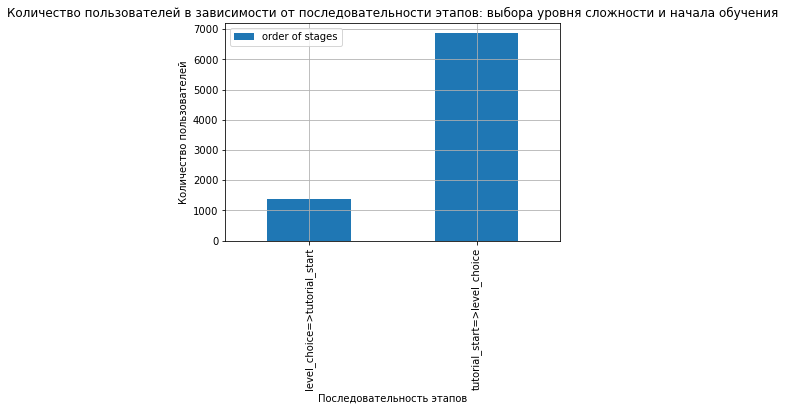

In [481]:
# визуализируем полученный результат
merged5_df.plot(
    kind='bar',
    grid=True,
    figsize=(6, 4),
    title= 'Количество пользователей в зависимости от последовательности этапов: выбора уровня сложности и начала обучения',
    xlabel= 'Последовательность этапов',
    ylabel= 'Количество пользователей'
);

## ВЫВОД
В связи с тем, что 20% пользователей проходят обучение уже после этапа выбора сложности, можем сделать вывод что приложение для пользователям не очень понятно. Стоит доработать приложение.

ссылка на файл
https://colab.research.google.com/drive/1RwrZN-LkS1cfuzh-XquOr2gE7JEiYhh6?usp=sharing